In [ ]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import polars as pl
from rich import print as pp
import os
from pandas import DataFrame

# Import the necessary libraries
import numpy as np
import scipy.stats as sts
import requests
import matplotlib.pyplot as plt
import pyfixest as pf


path_sample = "../data/process/sample.agg.csv"
df = pl.read_csv(path_sample).to_pandas()
df = df.sample(frac=0.3, random_state=42)
df.head(3)

,text,retweet,reply,like,quote,impression,is_reply,id,created_at,author_id,lang,text_raw,media,date,t,unique_id
390087,dozen hospit nyc appar overdo,34.0,14.0,16.0,8.0,0.0,False,7.532204e+17,2016-07-13 13:32:01+00:00,15012486.0,en,Dozens hospitalized in NYC for apparent K2 ove...,cbsnews,2016-07-13 13:32:01,27,390087
365245,florida sharp increa homicid bla...,179.0,58.0,135.0,32.0,0.0,False,8.049007e+17,2016-12-03 04:10:57+00:00,3108351.0,en,Florida is seeing a sharp increase in homicide...,wsj,2016-12-03 04:10:57,48,365245
388699,scott pelley remark feat pollst...,171.0,59.0,170.0,24.0,0.0,False,7.962258e+17,2016-11-09 05:39:57+00:00,15012486.0,en,"Scott Pelley: ""It is a remarkable feat. None o...",cbsnews,2016-11-09 05:39:57,44,388699


Similarity within each window

In [2]:
df_sim = pl.read_csv("../data/process/sim/similarity_scores.csv").to_pandas()
df_sim.head(3)

,unique_id,t,text,similarity_score
0,224,0,"50 comics walk into a club. (No, you haven’t h...",35.820866
1,245,0,A decades-long search for a perfect diet https...,42.679068
2,311,0,"Donald Trump finally buys TV ads, and lots of ...",47.639644


In [3]:
df = df.merge(
    df_sim[["unique_id", "similarity_score", "t"]], on=["t", "unique_id"], how="left"
)
df.head(3)

,text,retweet,reply,like,quote,impression,is_reply,id,created_at,author_id,lang,text_raw,media,date,t,unique_id,similarity_score
0,dozen hospit nyc appar overdo,34.0,14.0,16.0,8.0,0.0,False,7.532204e+17,2016-07-13 13:32:01+00:00,15012486.0,en,Dozens hospitalized in NYC for apparent K2 ove...,cbsnews,2016-07-13 13:32:01,27,390087,44.594601
1,florida sharp increa homicid bla...,179.0,58.0,135.0,32.0,0.0,False,8.049007e+17,2016-12-03 04:10:57+00:00,3108351.0,en,Florida is seeing a sharp increase in homicide...,wsj,2016-12-03 04:10:57,48,365245,44.073182
2,scott pelley remark feat pollst...,171.0,59.0,170.0,24.0,0.0,False,7.962258e+17,2016-11-09 05:39:57+00:00,15012486.0,en,"Scott Pelley: ""It is a remarkable feat. None o...",cbsnews,2016-11-09 05:39:57,44,388699,50.119793


## Coding

In [ ]:
threshold = np.mean(df["similarity_score"])
pp(f"Threshold: {threshold}")

Threshold: 45.10799209561763

<Axes: xlabel='is_unique'>

findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because

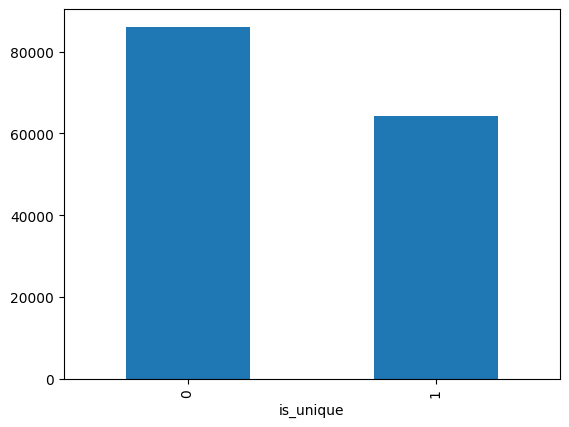

In [18]:
df["is_unique"] = df["similarity_score"].apply(lambda x: 1 if x < threshold else 0)
df.head(3)
df["is_unique"].value_counts()
df["is_unique"].value_counts().plot(kind="bar")

Stat

In [45]:
df_reg = (
    df.groupby(["t", "media"])
    .agg({"is_unique": "sum", "unique_id": "count"})
    .reset_index()
)
df_reg.columns = ["t", "i", "unique_count", "count"]
df_reg["unique_prop"] = df_reg["unique_count"] / df_reg["count"]
df_reg["sim_prop"] = 1 - df_reg["unique_prop"]
df_reg.head(10)

,t,i,unique_count,count,unique_prop,sim_prop
0,0,abc,64,64,1.000000,0.000000
1,0,bbcworld,29,57,0.508772,0.491228
2,0,breitbartnews,11,27,0.407407,0.592593
3,0,buzzfeednews,28,53,0.528302,0.471698
4,0,cbsnews,28,53,0.528302,0.471698
5,0,cnn,39,91,0.428571,0.571429
6,0,dailycaller,28,123,0.227642,0.772358
7,0,dcexaminer,20,106,0.188679,0.811321
8,0,foxnews,57,153,0.372549,0.627451
9,0,guardian,145,267,0.543071,0.456929


In [46]:
df_reg_all_outlets = (
    df_reg.groupby("t").agg({"unique_count": "sum", "count": "sum"}).reset_index()
)
df_reg_all_outlets.columns = ["t", "unique_count_all", "count_all"]
df_reg_all_outlets["unique_prop_all"] = (
    df_reg_all_outlets["unique_count_all"] / df_reg_all_outlets["count_all"]
)
df_reg_all_outlets["sim_prop_all"] = 1 - df_reg_all_outlets["unique_prop_all"]
df_reg_all_outlets.head()

,t,unique_count_all,count_all,unique_prop_all,sim_prop_all
0,0,1117,2435,0.458727,0.541273
1,1,1329,2848,0.466643,0.533357
2,2,1233,2772,0.444805,0.555195
3,3,1274,2693,0.473078,0.526922
4,4,1338,3072,0.435547,0.564453


In [47]:
df_reg_lead = df_reg.copy()
df_reg_lead["t"] = df_reg_lead["t"] - 1
df_reg_lead.head(3)

,t,i,unique_count,count,unique_prop,sim_prop
0,-1,abc,64,64,1.000000,0.000000
1,-1,bbcworld,29,57,0.508772,0.491228
2,-1,breitbartnews,11,27,0.407407,0.592593


In [48]:
df_reg = df_reg.merge(
    df_reg_lead,
    on=["t", "i"],
    how="left",
    suffixes=("", "_lead"),
).merge(
    df_reg_all_outlets,
    on=["t"],
    how="left",
    suffixes=("", "_all"),
)
df_reg.head(3)

,t,i,unique_count,count,unique_prop,sim_prop,unique_count_lead,count_lead,unique_prop_lead,sim_prop_lead,unique_count_all,count_all,unique_prop_all,sim_prop_all
0,0,abc,64,64,1.000000,0.000000,69.0,69.0,1.000000,0.000000,1117,2435,0.458727,0.541273
1,0,bbcworld,29,57,0.508772,0.491228,37.0,86.0,0.430233,0.569767,1117,2435,0.458727,0.541273
2,0,breitbartnews,11,27,0.407407,0.592593,13.0,34.0,0.382353,0.617647,1117,2435,0.458727,0.541273


In [59]:
df_reg["unique_count_comp"] = df_reg["unique_count_all"] - df_reg["unique_count"]
df_reg["unique_count_comp_prop"] = df_reg["unique_count_comp"] / (
    df_reg["count_all"] - df_reg["count"]
)

## Linear regression

In [36]:
# !pip install pyfixest

In [71]:
pp("No FE of media outlets:")
formula = "unique_prop_lead ~ unique_prop + unique_count_comp_prop  | t"
fit = pf.feols(formula, data=df_reg).summary()
pp("FE of media outlets:")
formula = "unique_prop_lead ~ unique_prop + unique_count_comp_prop  | t + i"
fit = pf.feols(formula, data=df_reg).summary()

No FE of media outlets:

###

Estimation:  OLS
Dep. var.: unique_prop_lead, Fixed effects: t
Inference:  CRV1
Observations:  1300

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| unique_prop            |      0.793 |        0.026 |    30.975 |      0.000 |  0.742 |   0.844 |
| unique_count_comp_prop |     -2.255 |        0.405 |    -5.563 |      0.000 | -3.069 |  -1.441 |
---
RMSE: 0.08 R2: 0.828 R2 Within: 0.814 


FE of media outlets:

###

Estimation:  OLS
Dep. var.: unique_prop_lead, Fixed effects: t+i
Inference:  CRV1
Observations:  1300

| Coefficient            |   Estimate |   Std. Error |   t value |   Pr(>|t|) |   2.5% |   97.5% |
|:-----------------------|-----------:|-------------:|----------:|-----------:|-------:|--------:|
| unique_prop            |      0.405 |        0.049 |     8.324 |      0.000 |  0.307 |   0.503 |
| unique_count_comp_prop |      2.177 |        0.860 |     2.533 |      0.014 |  0.451 |   3.903 |
---
RMSE: 0.068 R2: 0.876 R2 Within: 0.12 


## Structural Estimation

findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because

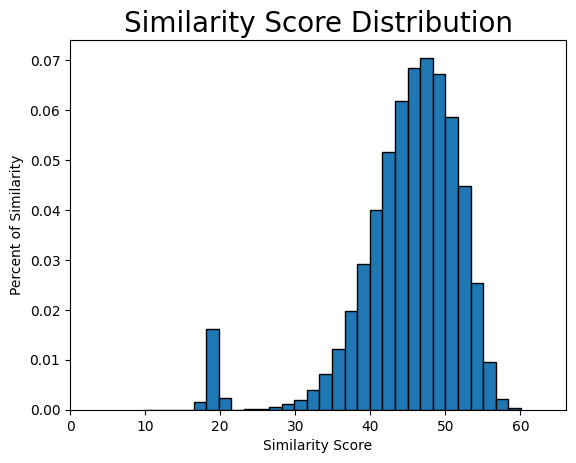

In [4]:
num_bins = 30
sim_scores = df.similarity_score
count, bins, ignored = plt.hist(sim_scores, num_bins, density=True, edgecolor="k")

plt.rcParams["font.sans-serif"] = ["arial"]  # or any font you have available
plt.title("Similarity Score Distribution", fontsize=20)
plt.xlabel(r"Similarity Score")  # Updated label for similarity scores
plt.ylabel(r"Percent of Similarity")  # Updated ylabel for clarity
plt.xlim([0, max(sim_scores) * 1.1])  # Adjust xlim based on max similarity score
plt.show()

In [5]:
# Define function that generates values of a normal pdf
def trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub):
    """
    --------------------------------------------------------------------
    Generate pdf values from the normal pdf with mean mu and standard
    deviation sigma. If the cutoff is given, then the PDF values are
    inflated upward to reflect the zero probability on values above the
    cutoff. If there is no cutoff given, this function does the same
    thing as sp.stats.norm.pdf(x, loc=mu, scale=sigma).
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cut_lb = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar lower bound value of distribution. Values below
             this value have zero probability
    cut_ub = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None

    OBJECTS CREATED WITHIN FUNCTION:
    prob_notcut = scalar
    pdf_vals = (N,) vector, normal PDF values for mu and sigma
               corresponding to xvals data

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: pdf_vals
    --------------------------------------------------------------------
    """
    if cut_ub == "None" and cut_lb == "None":
        prob_notcut = 1.0
    elif cut_ub == "None" and cut_lb != "None":
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != "None" and cut_lb == "None":
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != "None" and cut_lb != "None":
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma) - sts.norm.cdf(
            cut_lb, loc=mu, scale=sigma
        )

    pdf_vals = (
        1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-((xvals - mu) ** 2) / (2 * sigma**2))
    ) / prob_notcut

    return pdf_vals

findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because

MEMEMEM 0.9999999999999999


findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because

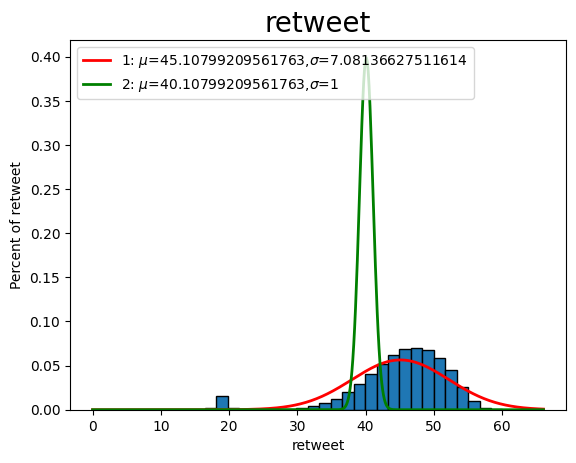

In [6]:
# Plot two different truncated normal distributions on top of the
# histogram of the data

# Plot histogram
num_bins = 30
cut_off = max(sim_scores) * 1.1
count, bins, ignored = plt.hist(sim_scores, num_bins, density=True, edgecolor="k")
plt.title("retweet", fontsize=20)
plt.xlabel(r"retweet")
plt.ylabel(r"Percent of retweet")
# plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"
print("MEMEMEM", (count * (bins[1:] - bins[:-1])).sum())

# Plot smooth line with distribution 1
dist_pts = np.linspace(0, cut_off, 500)
mu_1 = np.mean(sim_scores)
sig_1 = np.std(sim_scores)
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_1, sig_1, 0, cut_off),
    linewidth=2,
    color="r",
    label=f"1: $\mu$={mu_1},$\sigma$={sig_1}",
)
plt.legend(loc="upper left")

# Plot smooth line with distribution 2
mu_2 = np.mean(sim_scores) - 5
sig_2 = 1
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_2, sig_2, 0, cut_ub=cut_off),
    linewidth=2,
    color="g",
    label=f"2: $\mu$={mu_2},$\sigma$={sig_2}",
)
plt.legend(loc="upper left")
plt.show()

In [7]:
# Define log likelihood function for the normal distribution
def log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub):
    """
    --------------------------------------------------------------------
    Compute the log likelihood function for data xvals given normal
    distribution parameters mu and sigma.
    --------------------------------------------------------------------
    INPUTS:
    xvals  = (N,) vector, values of the normally distributed random
             variable
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        trunc_norm_pdf()

    OBJECTS CREATED WITHIN FUNCTION:
    pdf_vals    = (N,) vector, normal PDF values for mu and sigma
                  corresponding to xvals data
    ln_pdf_vals = (N,) vector, natural logarithm of normal PDF values
                  for mu and sigma corresponding to xvals data
    log_lik_val = scalar, value of the log likelihood function

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: log_lik_val
    --------------------------------------------------------------------
    """
    pdf_vals = trunc_norm_pdf(xvals, mu, sigma, cut_lb, cut_ub)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()

    return log_lik_val


print("Log-likelihood 1: ", log_lik_truncnorm(sim_scores, mu_1, sig_1, 0, 450))
print("Log-likelihood 2: ", log_lik_truncnorm(sim_scores, mu_2, sig_2, 0, 450))

Log-likelihood 1:  -507497.3662938847
Log-likelihood 2:  -5785588.8906542575


In [8]:
def crit(params, *args):
    """
    --------------------------------------------------------------------
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    --------------------------------------------------------------------
    INPUTS:
    params = (2,) vector, ([mu, sigma])
    mu     = scalar, mean of the normally distributed random variable
    sigma  = scalar > 0, standard deviation of the normally distributed
             random variable
    args   = length 2 tuple, (xvals, cutoff)
    xvals  = (N,) vector, values of the normally distributed random
             variable
    cutoff = scalar or string, ='None' if no cutoff is given, otherwise
             is scalar upper bound value of distribution. Values above
             this value have zero probability

    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION:
        log_lik_truncnorm()

    OBJECTS CREATED WITHIN FUNCTION:
    log_lik_val = scalar, value of the log likelihood function
    neg_log_lik_val = scalar, negative of log_lik_val

    FILES CREATED BY THIS FUNCTION: None

    RETURNS: neg_log_lik_val
    --------------------------------------------------------------------
    """
    mu, sigma = params
    xvals, cut_lb, cut_ub = args
    log_lik_val = log_lik_truncnorm(xvals, mu, sigma, cut_lb, cut_ub)
    neg_log_lik_val = -log_lik_val

    return neg_log_lik_val

In [9]:
import scipy.optimize as opt

mu_init = mu_2  # mu_2
sig_init = sig_2  # sig_2
params_init = np.array([mu_init, sig_init])
mle_args = (sim_scores, 0, 10.0)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args))
mu_MLE, sig_MLE = results_uncstr.x
print("mu_MLE=", mu_MLE, " sig_MLE=", sig_MLE)
pp(results_uncstr)

mu_MLE= 40.10799209561763  sig_MLE= 1.0


/home/rongxin/anaconda3/envs/data/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/home/rongxin/anaconda3/envs/data/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -62990448.729028374
        x: [ 4.011e+01  1.000e+00]
      nit: 0
      jac: [-5.282e+06  1.253e+08]
 hess_inv: [[1 0]
            [0 1]]
     nfev: 29
     njev: 6

findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: arial
findfont: Generic family 'sans-serif' not found because

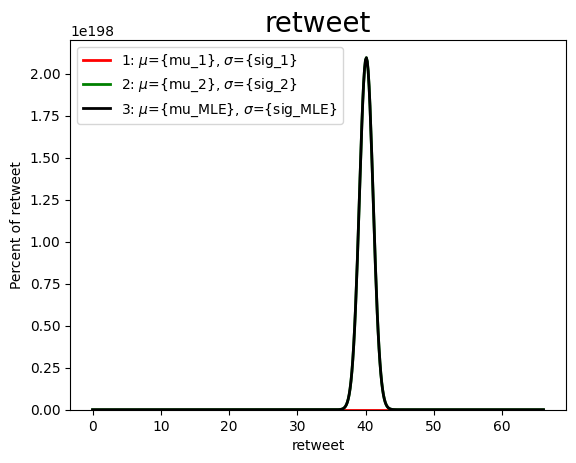

In [10]:
# Plot the histogram of the data
count, bins, ignored = plt.hist(sim_scores, num_bins, density=True, edgecolor="k")
plt.title("retweet", fontsize=20)
plt.xlabel(r"retweet")
plt.ylabel(r"Percent of retweet")
# plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

# Plot the two test distributions from before
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_1, sig_1, 0, 10),
    linewidth=2,
    color="r",
    label="1: $\mu$={mu_1}, $\sigma$={sig_1}",
)
plt.legend(loc="upper left")

plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_2, sig_2, 0, 10),
    linewidth=2,
    color="g",
    label="2: $\mu$={mu_2}, $\sigma$={sig_2}",
)
plt.legend(loc="upper left")

# Plot the MLE estimated distribution
plt.plot(
    dist_pts,
    trunc_norm_pdf(dist_pts, mu_MLE, sig_MLE, 0, 10),
    linewidth=2,
    color="k",
    label="3: $\mu$={mu_MLE}, $\sigma$={sig_MLE}",
)
plt.legend(loc="upper left")
# plt.savefig("images/MLEplots.png")

In [11]:
# import matplotlib
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib import cm

# cmap1 = matplotlib.cm.get_cmap("summer")

# mu_vals = np.linspace(mu_MLE - 30, mu_MLE + 30, 50)
# sig_vals = np.linspace(sig_MLE - 30, sig_MLE + 30, 50)
# # mu_vals = np.linspace(0.98*mu_MLE, 1.02*mu_MLE, 50)
# # sig_vals = np.linspace(0.98*sig_MLE, 1.02*sig_MLE, 50)
# lnlik_vals = np.zeros((50, 50))
# for mu_ind in range(50):
#     for sig_ind in range(50):
#         lnlik_vals[mu_ind, sig_ind] = log_lik_truncnorm(
#             log_count, mu_vals[mu_ind], sig_vals[sig_ind], 0, 450
#         )

# mu_mesh, sig_mesh = np.meshgrid(mu_vals, sig_vals)

# fig = plt.figure()
# ax = fig.add_subplot(111, projection="3d")
# ax.plot_surface(sig_mesh, mu_mesh, lnlik_vals, rstride=8, cstride=1, cmap=cmap1)
# ax.set_title("Log likelihood for values of mu and sigma")
# ax.set_xlabel(r"$\sigma$")
# ax.set_ylabel(r"$\mu$")
# ax.set_zlabel(r"log likelihood")
# fig.show()